# Random Walk Algorithm

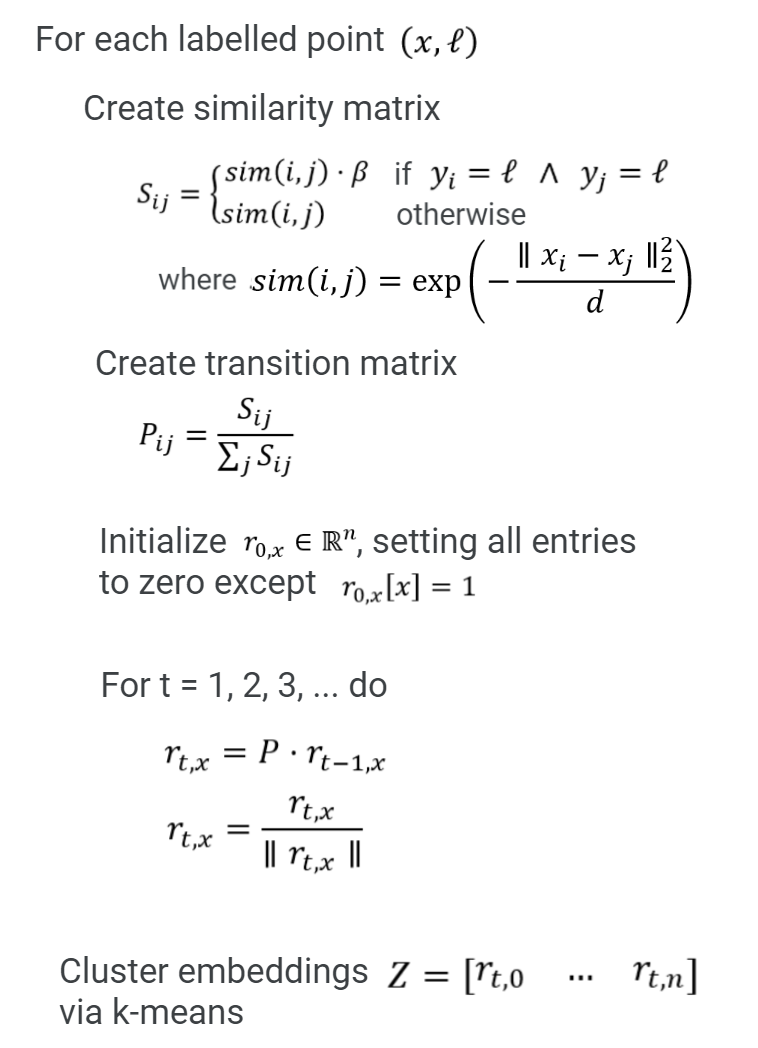

In [1]:
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from fastdist import fastdist
from numba import jit
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_moons

project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
    
from app.algorithms import random_walk
from app.data.datasets import SyntheticDataSet
from app.data.noise import compute_corruption_ratio_per_class, apply_noise_to_labels

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, accuracy_score


import utils

In [2]:
%load_ext autoreload
%autoreload 2

# Gaussians

In [3]:
data_set = SyntheticDataSet(
    n_dim=2,
    min_distance=2,
    component_size=250,
    variance=0.5,
    label_noise_proba=0.45,
)

In [4]:
df_data = data_set._df.copy()

In [5]:
compute_corruption_ratio_per_class(df=df_data)

corruption_ratio
true_label                  
0                      0.460
1                      0.492

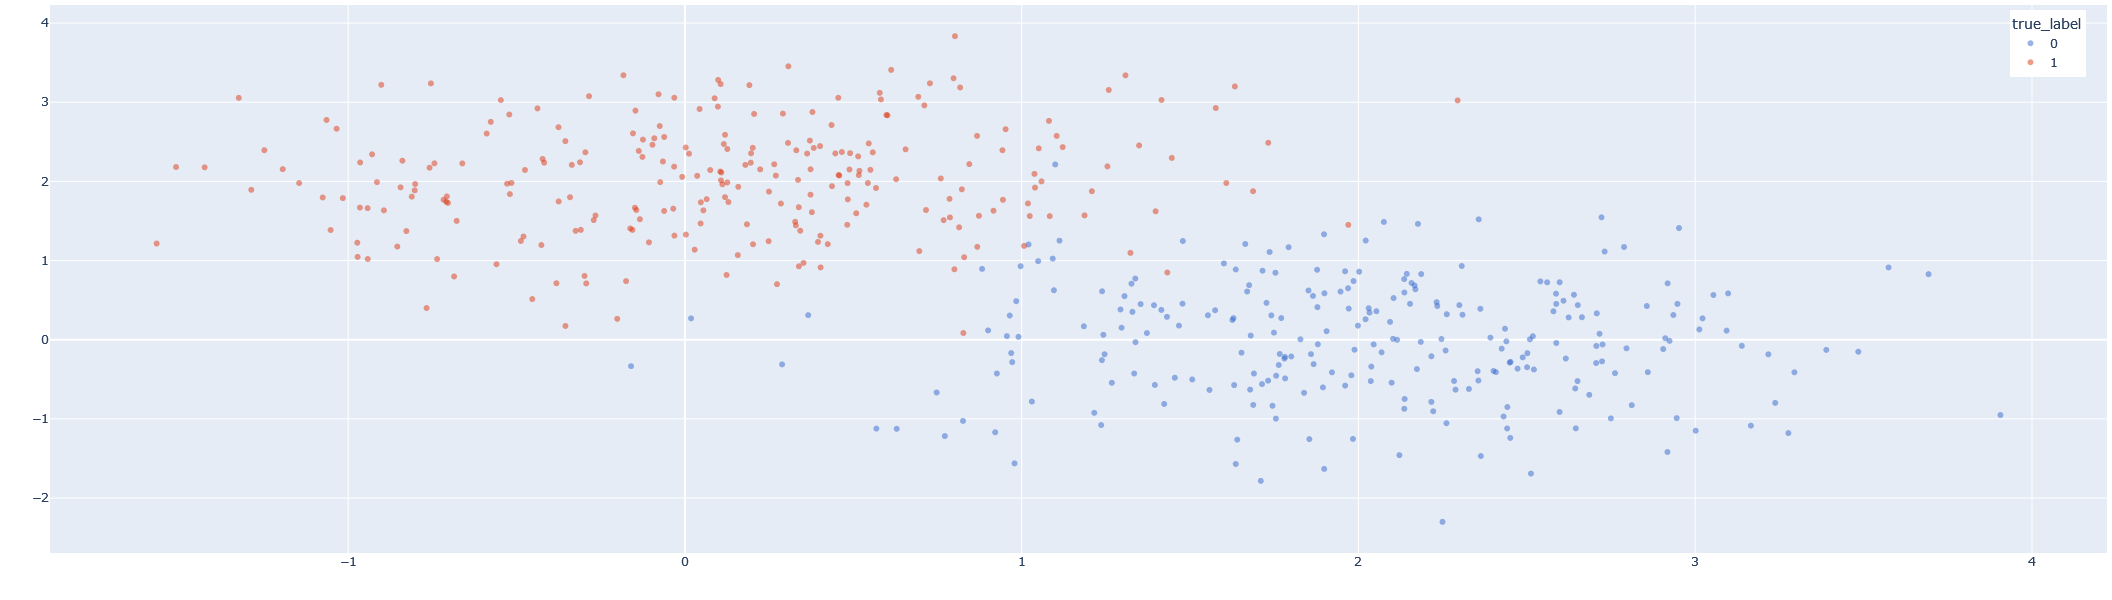

In [6]:
utils.plot_2d(df_data, color_attr="true_label")

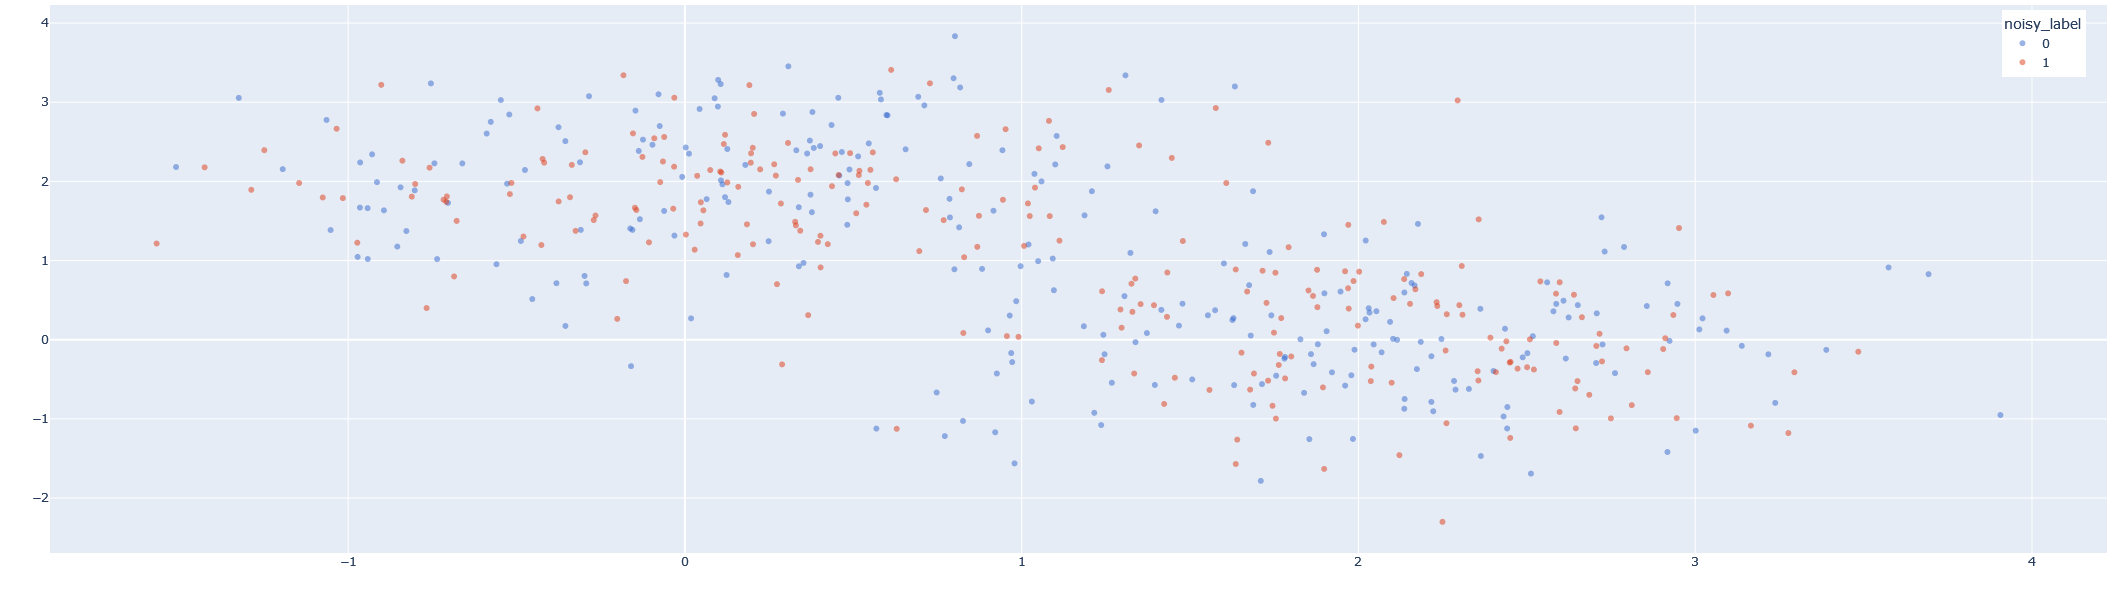

In [7]:
utils.plot_2d(df_data)

In [8]:
X = data_set.features.to_numpy()
y = data_set.labels.to_numpy()

print(f"The shape of the generated data matrix is: {X.shape}")

The shape of the generated data matrix is: (500, 2)


### Animation

In [9]:
distance_matrix = pairwise_distances(X, metric="sqeuclidean")
similarity_matrix = np.exp(-distance_matrix / X.shape[1])
np.fill_diagonal(similarity_matrix, val=0.0)
transition_matrix = (similarity_matrix / similarity_matrix.sum(axis=1).reshape(-1, 1)).T

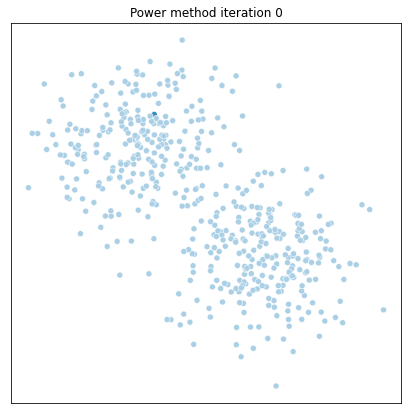

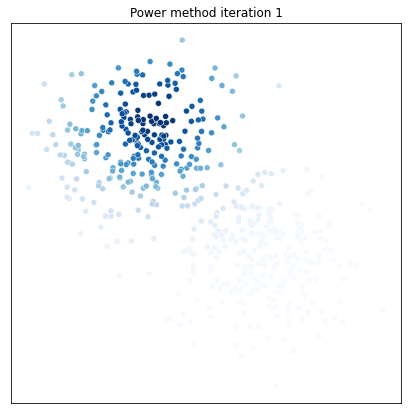

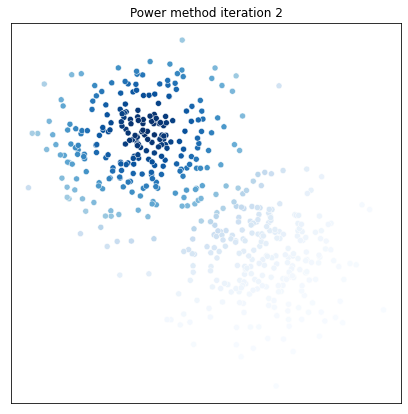

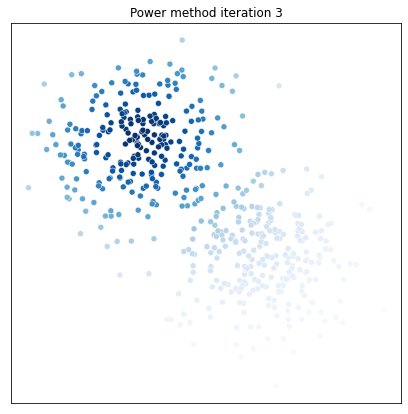

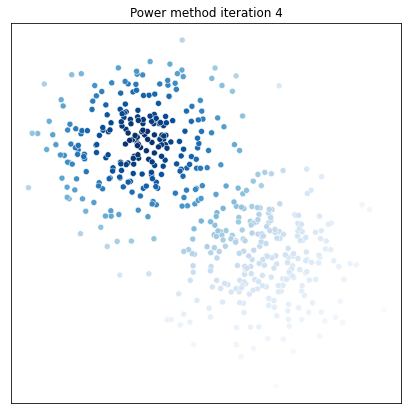

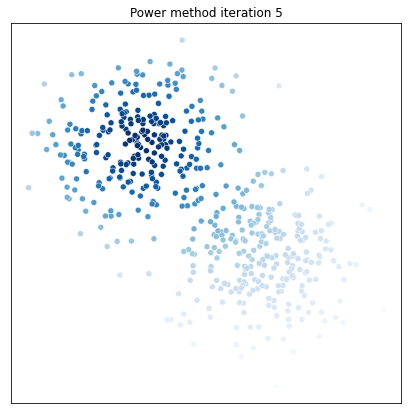

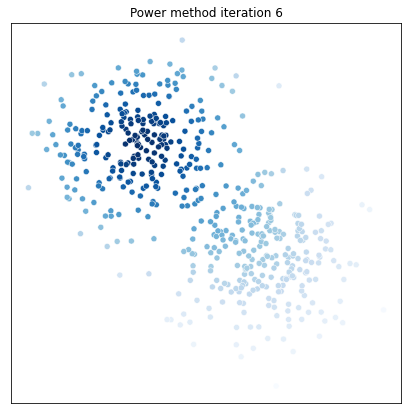

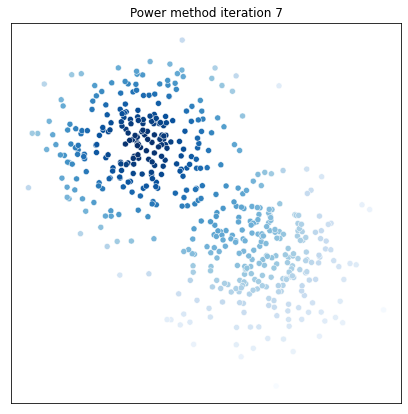

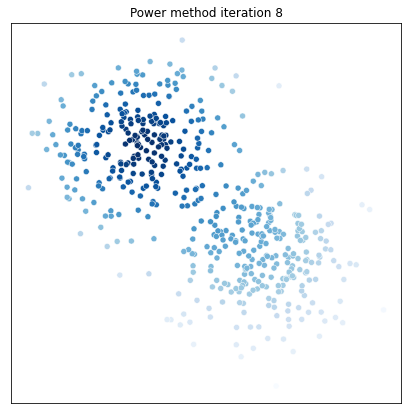

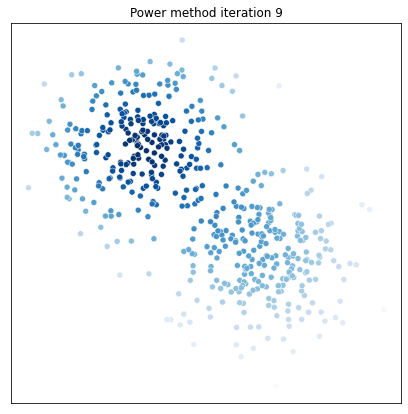

In [10]:
# Initialize with a random vector
r = np.zeros(transition_matrix.shape[0])
r[410] = 1
# r = r / r.sum()
#r[df_data.label == 0] = 1

converged = False
n_iterations = 10
for iteration in range(n_iterations):
    df_data["score"] = r
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(x='feat_0', y='feat_1', hue='score', data=df_data, palette="Blues", ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f"Power method iteration {iteration}")
    ax.legend().remove()
    
    r_prev = r.copy()  
    r = np.dot(transition_matrix, r)  # Power method
    
    r = r / np.linalg.norm(r)  # Normalize
    if np.allclose(r, r_prev): # Check convergence
        print(f"SUCCESS: Power method converged at iteration {iteration}")
        converged = True
        break


### Single Step

In [11]:
print(f"Computing embeddings via random walks.")
embeddings = random_walk.compute_random_walk_embeddings(
    X=X,
    y=y,
    n_steps=1,
    bias_factor=1.000,
    distance_metric="sqeuclidean",
    allow_self_loops=False,
)

Computing embeddings via random walks.
2022-07-01 15:28:42,173 [DEBUG|random_walk ] Computing pairwise distances
2022-07-01 15:28:42,176 [DEBUG|random_walk ] Computing similarity matrix
2022-07-01 15:28:42,180 [DEBUG|random_walk ] Processing class 0
2022-07-01 15:28:43,186 [DEBUG|random_walk ] Processing class 1


In [12]:
n_classes = 1*np.unique(y).shape[0]
print(f"Running k-Means with k={n_classes}")
kmeans = KMeans(n_clusters=n_classes)
kmeans.fit(embeddings)

Running k-Means with k=2


KMeans(n_clusters=2)

In [13]:
df_data_copy = df_data.copy()

df_data_copy["cluster_label"] = kmeans.labels_

df_data_copy = utils.assign_labels_based_on_clusters(
    df_results=df_data_copy,
    new_column_name="pred_label"
)

In [14]:
accuracy_score(y_true=df_data_copy["true_label"], y_pred=df_data_copy["pred_label"])

0.5

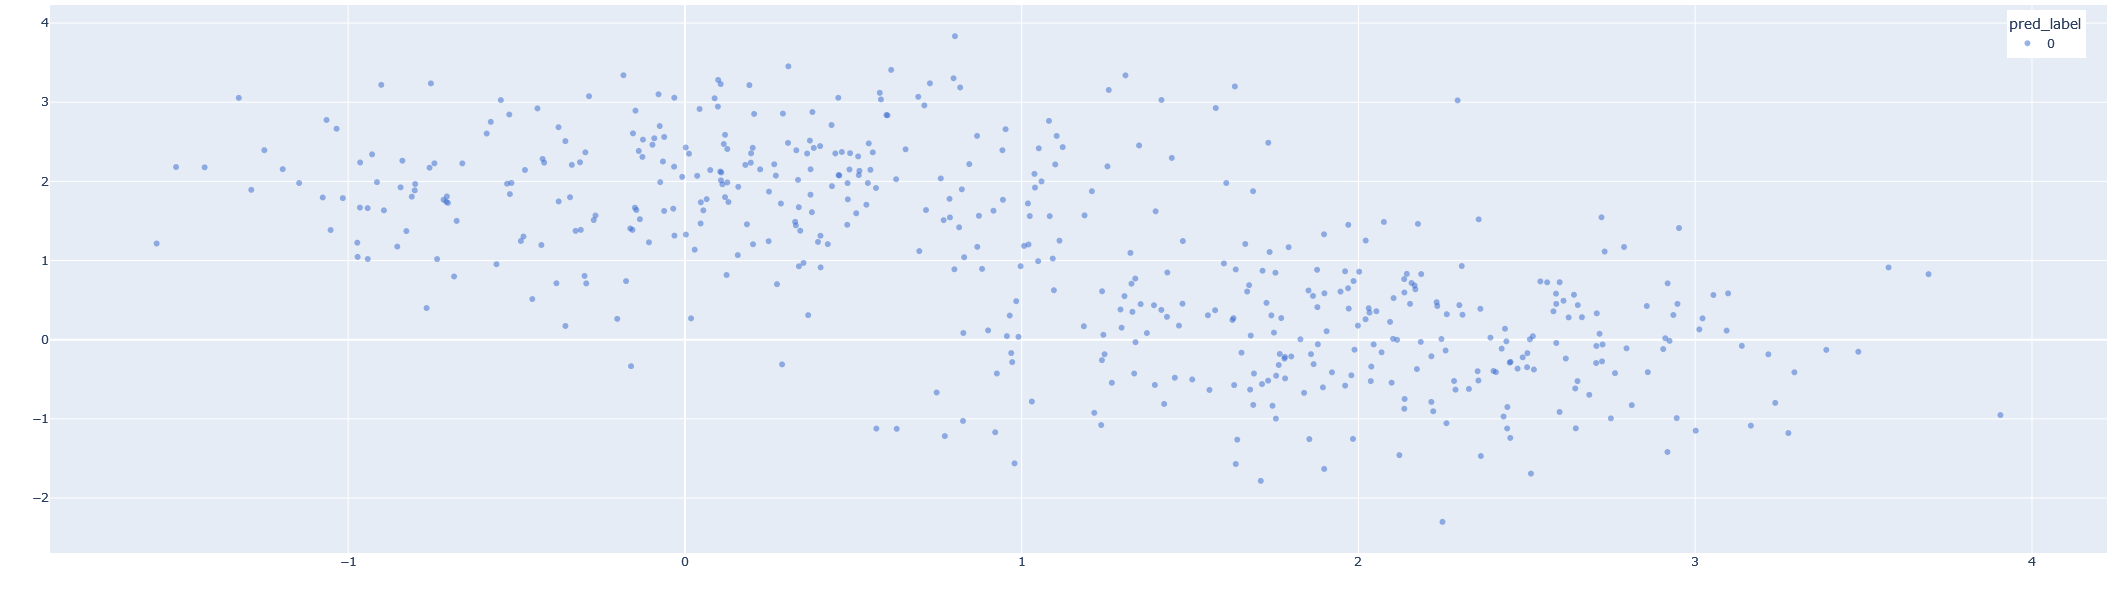

In [15]:
utils.plot_2d(df_data_copy, "pred_label")

## Moons dataset

In [16]:
X, y = make_moons(n_samples=500, noise=0.1)
df_data = pd.DataFrame({ **{ f"feat_{j}": X[:, j] for j in range(X.shape[1]) } })
df_data["true_label"] = y
apply_noise_to_labels(df=df_data, label_noise_proba=0.40)

In [17]:
compute_corruption_ratio_per_class(df=df_data)

corruption_ratio
true_label                  
0                      0.360
1                      0.444

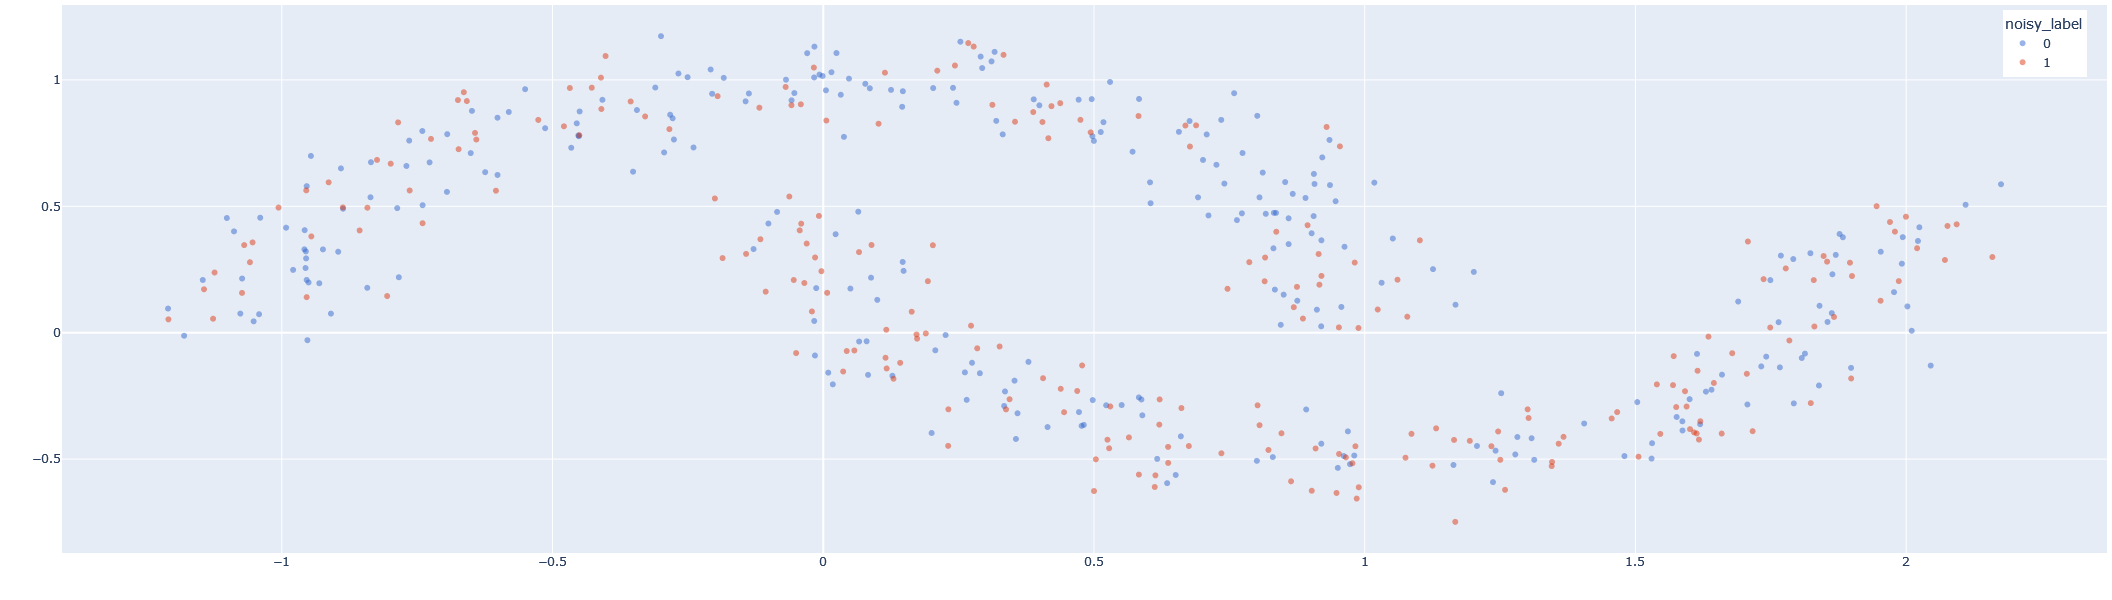

In [18]:
utils.plot_2d(df_data)

In [19]:
y = df_data.noisy_label

print(f"The shape of the generated data matrix is: {X.shape}")

The shape of the generated data matrix is: (500, 2)


In [20]:
print(f"Computing embeddings via random walks.")
embeddings = random_walk.compute_random_walk_embeddings(
    X=X,
    y=y,
    n_steps=1,
    bias_factor=1.00,
    distance_metric="sqeuclidean",
    allow_self_loops=False,
)

Computing embeddings via random walks.
2022-07-01 15:28:44,075 [DEBUG|random_walk ] Computing pairwise distances
2022-07-01 15:28:44,077 [DEBUG|random_walk ] Computing similarity matrix
2022-07-01 15:28:44,079 [DEBUG|random_walk ] Processing class 0
2022-07-01 15:28:44,091 [DEBUG|random_walk ] Processing class 1


In [21]:
n_classes = 4*np.unique(y).shape[0]
print(f"Running k-Means with k={n_classes}")
kmeans = KMeans(n_clusters=n_classes)
kmeans.fit(embeddings)

Running k-Means with k=8


KMeans()

In [22]:
df_data_copy = df_data.copy()

df_data_copy["cluster_label"] = kmeans.labels_

df_data_copy = utils.assign_labels_based_on_clusters(
    df_results=df_data_copy,
    new_column_name="pred_label"
)

In [23]:
accuracy_score(y_true=df_data_copy["true_label"], y_pred=df_data_copy["pred_label"])

0.994

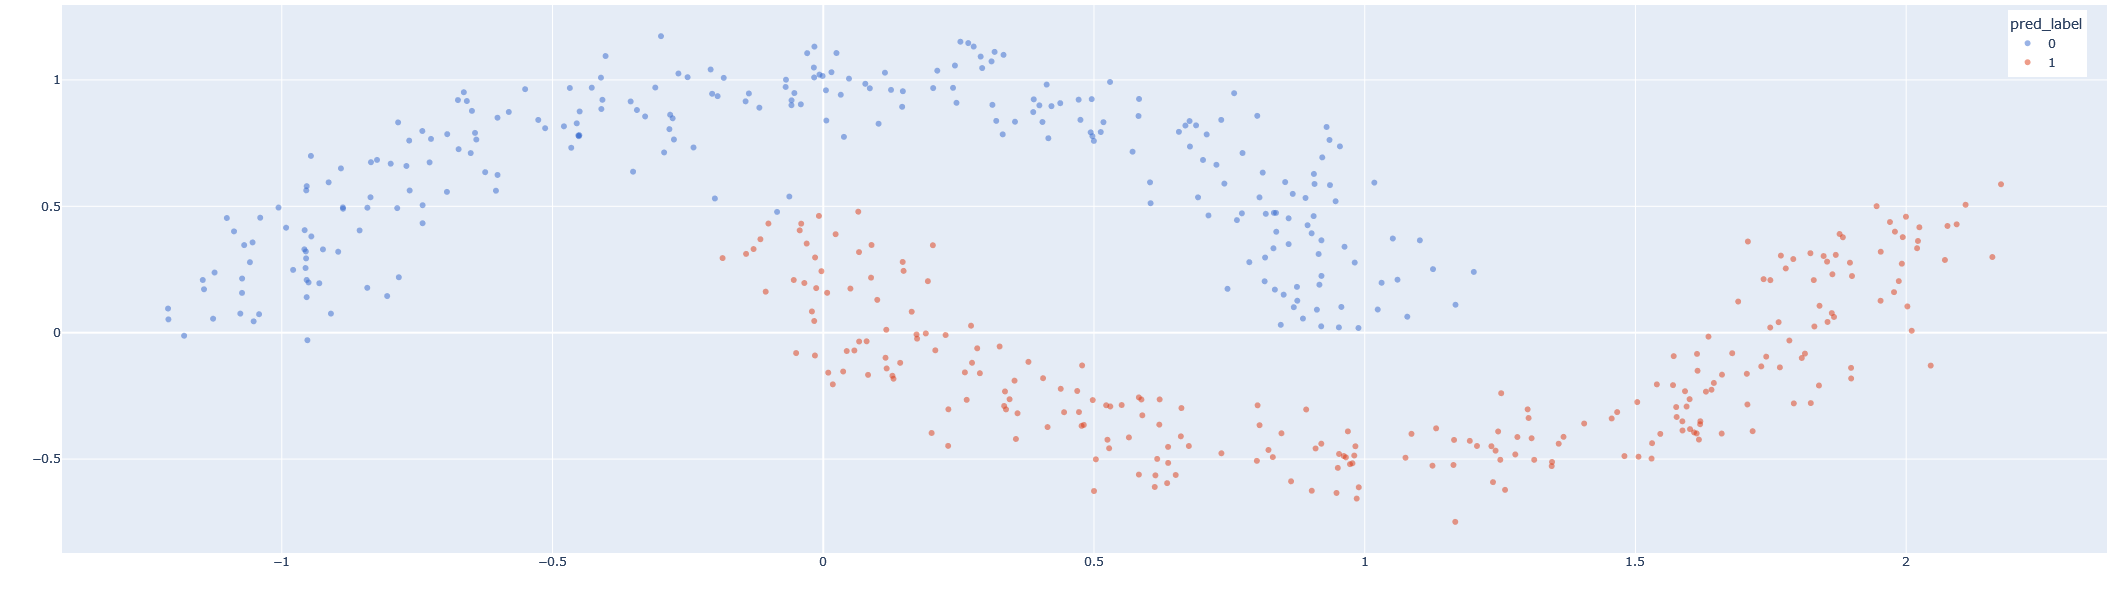

In [24]:
utils.plot_2d(df_data=df_data_copy, color_attr="pred_label")

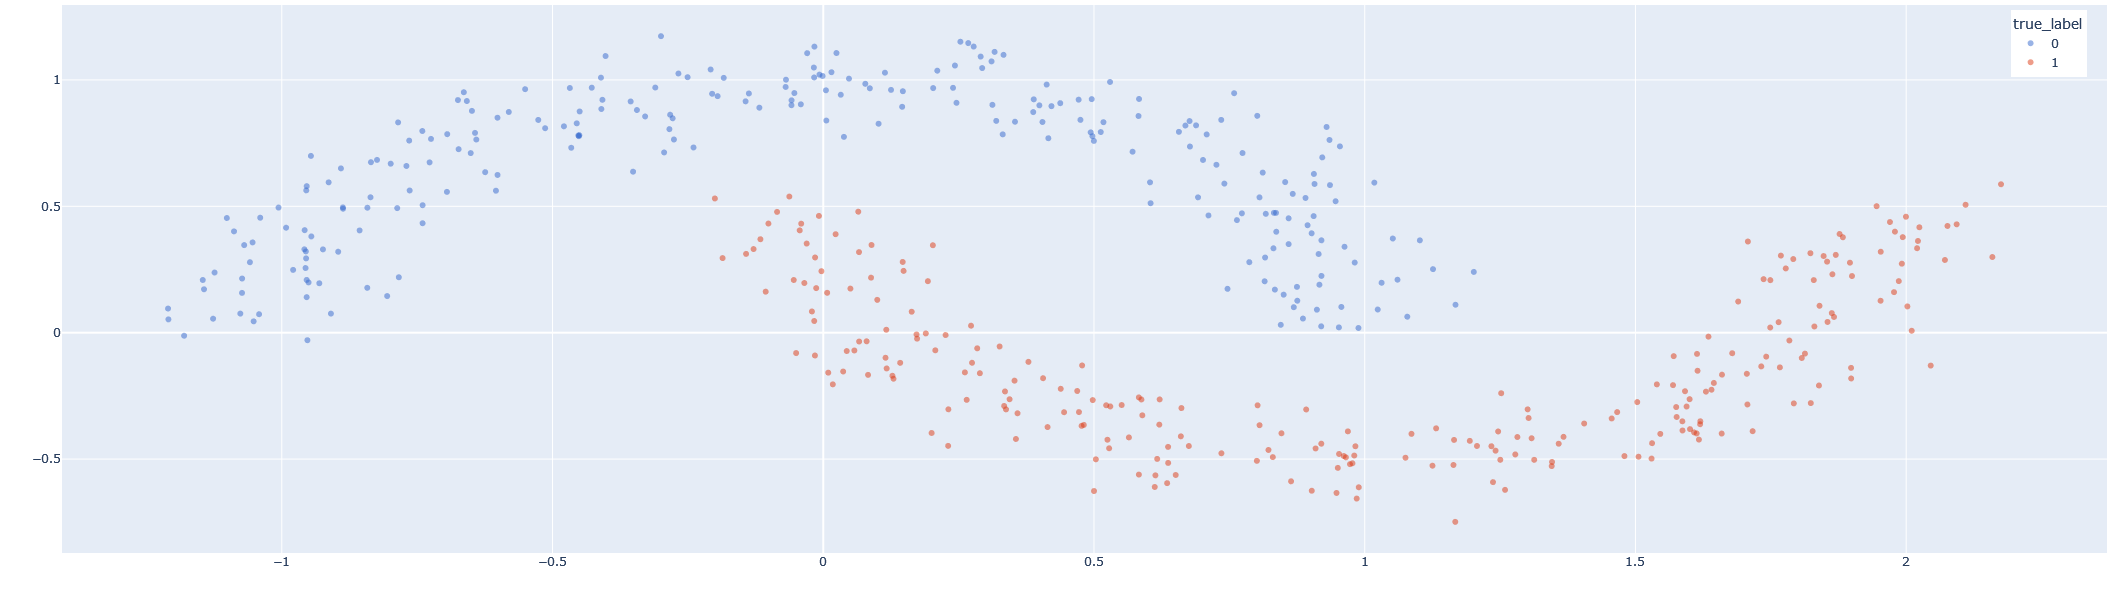

In [25]:
utils.plot_2d(df_data=df_data_copy, color_attr="true_label")